In [107]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.datasets import fashion_mnist
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline

## Частина 2 ##

В цій частині ми знову будемо працювати з датасетом fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.

Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.

Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

### __Допоміжні функції__ ###

In [2]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)


set_seed(42)


def loss_accuracy_plotting(history: dict, title: str=None, title_y=1.1):
    num_epochs = len(history[list(history.keys())[0]])

    x = np.arange(1, num_epochs + 1)
    x_xticks = np.arange(0, num_epochs+1, num_epochs//10)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4),
                                   gridspec_kw={"wspace": 0.2})

    ax1.plot(x, history["loss"])
    ax1.plot(x, history["val_loss"])
    ax1.set_title("loss and val_loss")

    ax2.plot(x, history["categorical_accuracy"])
    ax2.plot(x ,history["val_categorical_accuracy"])
    ax2.set_title("accuracy and val_accuracy")

    ax1.grid(True)
    ax1.set_xticks(x_xticks)
    ax1.set_xlabel("epochs")

    ax2.grid(True)
    ax2.set_xticks(x_xticks)
    ax2.set_xlabel("epochs")

    if title:
        fig.suptitle(title, y=title_y)
    plt.show()


def evaluate_model(model: Sequential, history: dict):
    score_train = model.evaluate(x_train, y_train, verbose=0)
    score_test = model.evaluate(x_test, y_test, verbose=0)
    print(f"Train loss: {score_train[0]}, train accuracy: {score_train[1]}")
    print(f"Test loss:  {score_test[0]}, test accuracy:  {score_test[1]}")

    print("\nTrain")
    print(f"Min loss : {np.array(history['loss']).min()}, "
          f"epoch num: {np.argmin(history['loss']) + 1}")
    print(f"Max accuracy : {np.array(history['categorical_accuracy']).max()}, "
          f"epoch num: {np.argmax(history['categorical_accuracy']) + 1}")
    print("\nValidation")
    print(f"Min loss : {np.array(history['val_loss']).min()}, "
          f"epoch num: {np.argmin(history['val_loss']) + 1}")
    print(f"Max accuracy : {np.array(history['val_categorical_accuracy']).max()}, "
          f"epoch num: {np.argmax(history['val_categorical_accuracy']) + 1}")

### __Підготовка данних__ ###

In [58]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = tf.expand_dims(x_train, -1)
x_train = tf.image.grayscale_to_rgb(tf.image.resize(x_train, [32,32]))
x_test = tf.expand_dims(x_test, -1)
x_test = tf.image.grayscale_to_rgb(tf.image.resize(x_test, [32,32]))

# x_train = x_train / 255.
# x_test = x_test / 255.

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train = tf.keras.applications.vgg16.preprocess_input(x_train)
x_test = tf.keras.applications.vgg16.preprocess_input(x_test)
x_train.shape

TensorShape([60000, 32, 32, 3])

 ### __Створимо згортку на основі VGG16__ ###

In [129]:
conv_base = VGG16(include_top=False, weights="imagenet", input_shape=(32, 32, 3))
conv_base.trainable = False

In [61]:
n_epochs = 50
batch_size = 512

In [62]:
model = Sequential([
   conv_base,
   Flatten(),
   Dropout(0.3),
   Dense(256, activation="relu"),
   Dense(10, activation="softmax"),
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

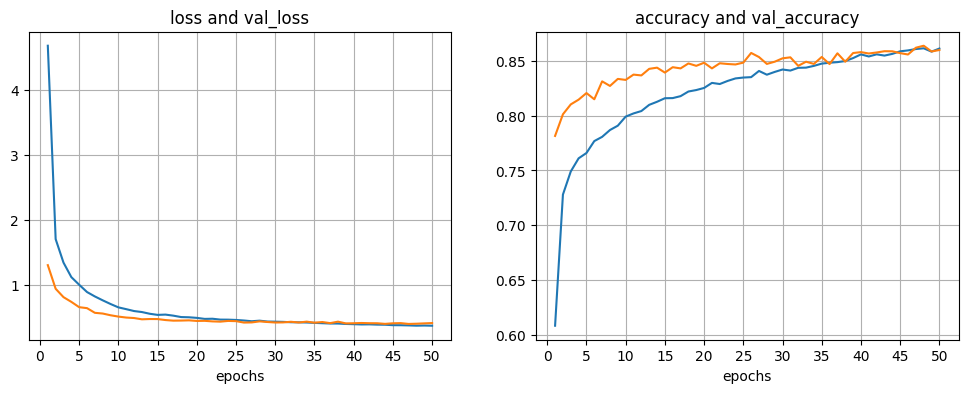

In [64]:
history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)
loss_accuracy_plotting(model.history.history)

In [65]:
evaluate_model(model, model.history.history)

Train loss: 0.2901313006877899, train accuracy: 0.894266664981842
Test loss:  0.4265943467617035, test accuracy:  0.8533999919891357

Train
Min loss : 0.36766207218170166, epoch num: 50
Max accuracy : 0.8613125085830688, epoch num: 48

Validation
Min loss : 0.3952256739139557, epoch num: 47
Max accuracy : 0.8636666536331177, epoch num: 48


__Результат жахливий що на трейні що на тесті__

### __Спробуємо дещо змінити ресайз зображень та ускладнити модель додавши ще один шар__ ###

In [200]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = tf.expand_dims(x_train, -1)
x_train = tf.image.grayscale_to_rgb(tf.image.resize_with_pad(x_train, 32, 32))
x_test = tf.expand_dims(x_test, -1)
x_test = tf.image.grayscale_to_rgb(tf.image.resize_with_pad(x_test, 32, 32))

# x_train = x_train / 255.
# x_test = x_test / 255.

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train = tf.keras.applications.vgg16.preprocess_input(x_train)
x_test = tf.keras.applications.vgg16.preprocess_input(x_test)
x_train.shape

TensorShape([60000, 32, 32, 3])

In [70]:
model = Sequential([
   conv_base,
   Flatten(),
   Dropout(0.3),
   Dense(256, activation="relu"),
   Dense(128, activation="relu"),
   Dense(10, activation="softmax"),
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

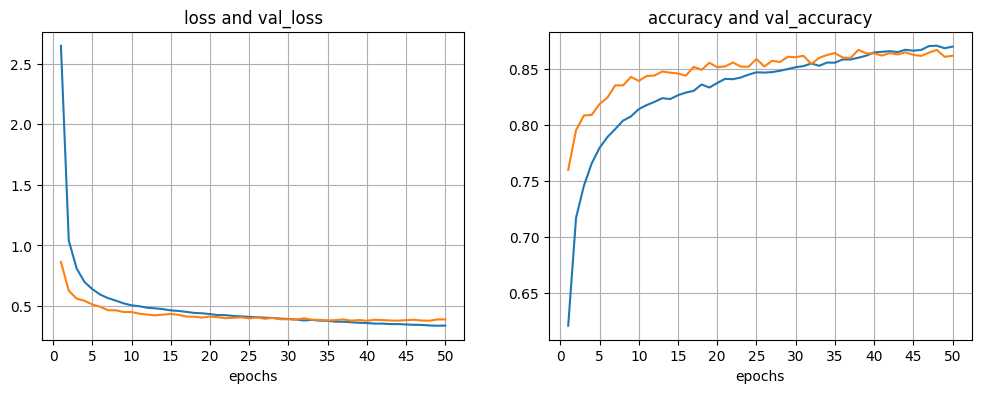

In [72]:
history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2)
loss_accuracy_plotting(model.history.history)

In [79]:
evaluate_model(model, model.history.history)

Train loss: 0.3108138144016266, train accuracy: 0.8888833522796631
Test loss:  0.3882468342781067, test accuracy:  0.8618999719619751

Train
Min loss : 0.40567949414253235, epoch num: 49
Max accuracy : 0.8463749885559082, epoch num: 49

Validation
Min loss : 0.3754032850265503, epoch num: 50
Max accuracy : 0.8665000200271606, epoch num: 49


__Без особливих покращень__

### __Ще один шар для заспокоення совісті__ ###

In [97]:
model = Sequential([
   conv_base,
   Flatten(),
   Dropout(0.2),
   Dense(256, activation="relu"),
   Dropout(0.1),
   Dense(128, activation="relu"),
   Dropout(0.1),
   Dense(64, activation="relu"),
   Dropout(0.1),
   Dense(10, activation="softmax"),
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

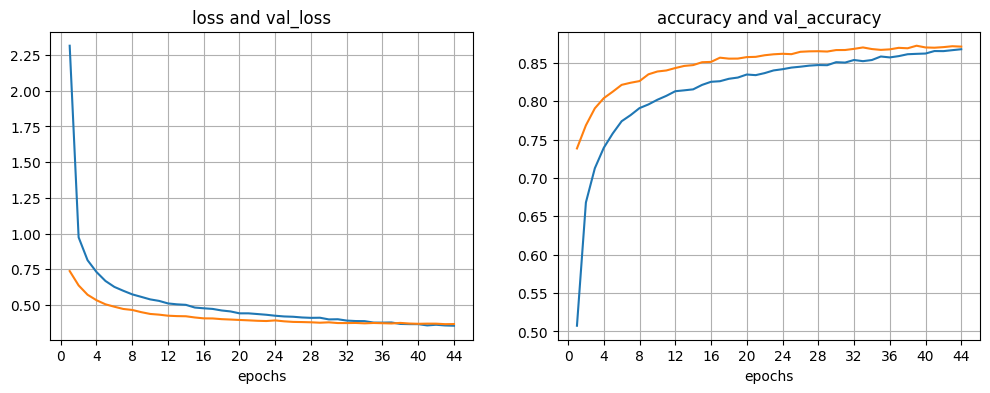

Train loss: 0.26995500922203064, train accuracy: 0.9014000296592712
Test loss:  0.3782064914703369, test accuracy:  0.8626999855041504

Train
Min loss : 0.3549070954322815, epoch num: 44
Max accuracy : 0.8677499890327454, epoch num: 44

Validation
Min loss : 0.3658094108104706, epoch num: 43
Max accuracy : 0.8723333477973938, epoch num: 39


In [98]:
history = model.fit(x_train, y_train, epochs=44, batch_size=batch_size, validation_split=0.2, verbose=0)
loss_accuracy_plotting(model.history.history)
evaluate_model(model, model.history.history)

__Починає приходити розуміння, що на вхід повнозв'язних шарів подаємо інформацію, яка не зовсім влаштовує FNN для якісного навчання. Вихід - розморозка верхніх шарів VGG__

### __Далі йдемо по конспекту__ ###

In [106]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


In [122]:
model_1 = Sequential([
   conv_base,
   Flatten(),
   Dropout(0.2),
   Dense(256, activation="relu"),
   Dropout(0.1),
   Dense(128, activation="relu"),
   Dropout(0.1),
   Dense(64, activation="relu"),
   Dropout(0.1),
   Dense(10, activation="softmax"),
])

model_1.compile(optimizer=RMSprop(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [123]:
model_1.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_25 (Flatten)        (None, 512)               0         
                                                                 
 dropout_49 (Dropout)        (None, 512)               0         
                                                                 
 dense_86 (Dense)            (None, 256)               131328    
                                                                 
 dropout_50 (Dropout)        (None, 256)               0         
                                                                 
 dense_87 (Dense)            (None, 128)               32896     
                                                                 
 dropout_51 (Dropout)        (None, 128)             

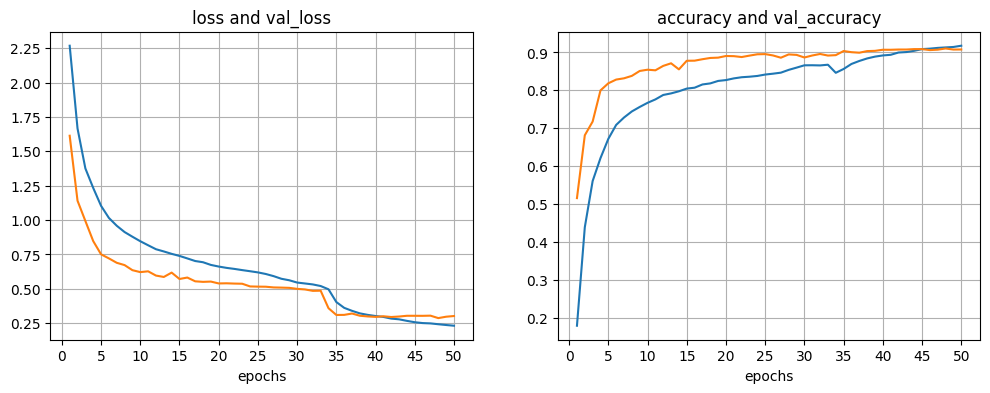

In [125]:
history = model_1.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
loss_accuracy_plotting(model_1.history.history)

In [127]:
evaluate_model(model_1, model_1.history.history)

Train loss: 0.15693862736225128, train accuracy: 0.9488166570663452
Test loss:  0.32085296511650085, test accuracy:  0.9021000266075134

Train
Min loss : 0.2318839728832245, epoch num: 50
Max accuracy : 0.9177708625793457, epoch num: 50

Validation
Min loss : 0.2872825562953949, epoch num: 48
Max accuracy : 0.9104999899864197, epoch num: 48


__Стало краще__

### __Чому б не спробувати підняти планку розморози вище?__ ###

In [190]:
conv_base_1 = VGG16(include_top=False, weights="imagenet", input_shape=(32, 32, 3))
conv_base_1.trainable = True
set_trainable = False
for layer in conv_base_1.layers:
    if layer.name == "block4_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


In [191]:
model_2 = Sequential([
   conv_base_1,
   Flatten(),
   Dropout(0.5),
   Dense(256, activation="relu"),
   Dropout(0.3),
   Dense(128, activation="relu"),
   Dropout(0.2),
   Dense(10, activation="softmax"),
])

model_2.compile(optimizer=RMSprop(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [192]:
model_2.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_36 (Flatten)        (None, 512)               0         
                                                                 
 dropout_81 (Dropout)        (None, 512)               0         
                                                                 
 dense_121 (Dense)           (None, 256)               131328    
                                                                 
 dropout_82 (Dropout)        (None, 256)               0         
                                                                 
 dense_122 (Dense)           (None, 128)               32896     
                                                                 
 dropout_83 (Dropout)        (None, 128)             

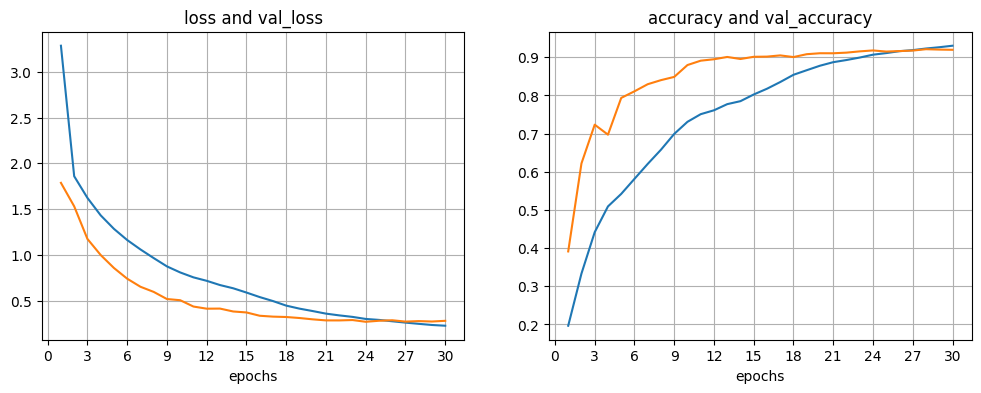

Train loss: 0.16535469889640808, train accuracy: 0.9491666555404663
Test loss:  0.2963951826095581, test accuracy:  0.9158999919891357

Train
Min loss : 0.22762003540992737, epoch num: 30
Max accuracy : 0.9303749799728394, epoch num: 30

Validation
Min loss : 0.2706066071987152, epoch num: 24
Max accuracy : 0.9212499856948853, epoch num: 28


In [193]:
history = model_2.fit(x_train, y_train, epochs=30, batch_size=batch_size, validation_split=0.2, verbose=0)
loss_accuracy_plotting(model_2.history.history)
evaluate_model(model_2, model_2.history.history)

__На сьогодні найкращий результат, хоч і невеликим перенавчанням__

### __Матриця помилок, щоб хоч трохи прикрасити кволі результати__ ###

In [194]:
pred_test = model_2.predict(x_test)
acc_test = categorical_accuracy(y_test, pred_test).numpy().mean()
print(f"Точність по всьому тестовому датасеті: {acc_test}")

313/313 [==============================] - 2s 7ms/step
Точність по всьому тестовому датасеті: 0.9158999919891357


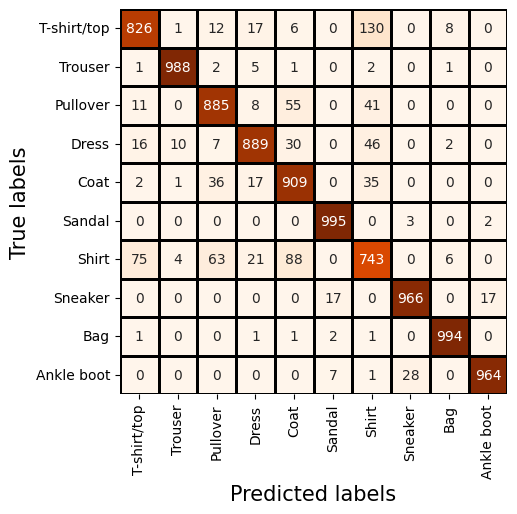

In [212]:
labels = ["T-shirt/top",
          "Trouser",
          "Pullover",
          "Dress",
          "Coat",
          "Sandal",
          "Shirt",
          "Sneaker",
          "Bag",
          "Ankle boot"]

y_pred = tf.argmax(pred_test, axis=1)

cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
df_confusion_matrix = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(5, 5))
sns.heatmap(df_confusion_matrix, fmt="d", annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black")
plt.xlabel("Predicted labels", fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel("True labels", fontsize=15)
plt.yticks(fontsize=10, rotation=0);

### __Порівняння з CNN-нейромережею з першої частини.__ ###
- Отримана точність на тестовій вибірці: CNN-VDD - 0.9159, CNN - 0.9311, дельта - 0,0152
- Точність на Shirt: CNN-VDD - 0.743,  CNN - 0.857,  дельта - __0,114 !!!__
- Швидкість тренування: CNN-VDD не критично програє СNN з минулої частини.

## __Висновок__ ##

__Використання попередньо навченої мережі це звичайно добре. Але ВИДІЛЕННЯ ОЗНАК буде працювати тим краще чим більше корелюються  наші данні та данні, на яких тренувалася попередньо навчена мережа. В нашому випадку мені здалося це не зовсім так. Що до використання ДОНАВЧАННЯ - то ця техніка виглядає більш універсальною за рахунок використання добре навчених фільтрів для розпізнавання примітивних патернів, які є загальними для більшості зображень.__